# Классификация 128x128 + U-Net c бэкбоном

## Датасеты
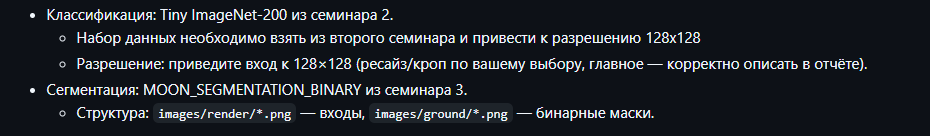

In [15]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2025-12-14 22:04:03--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-12-14 22:04:03--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... No data received.
Retrying.

--2025-12-14 22:04:06--  (try: 2)  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... ^C


In [16]:
!unzip -q tiny-imagenet-200.zip

In [17]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [18]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir

        # все 200 классов
        with open(os.path.join(root_dir, 'wnids.txt')) as f:
            self.wnids = [line.strip() for line in f]

        self.class_to_idx = {wnid: i for i, wnid in enumerate(self.wnids)}

        self.samples = []
        self._load_train()
        self._load_val()

    def _load_train(self):
        train_dir = os.path.join(self.root_dir, 'train')
        for wnid in os.listdir(train_dir):
            img_dir = os.path.join(train_dir, wnid, 'images')
            if not os.path.isdir(img_dir):
                continue
            for img in os.listdir(img_dir):
                path = os.path.join(img_dir, img)
                label = self.class_to_idx[wnid]
                self.samples.append((path, label))

    def _load_val(self):
        val_img_dir = os.path.join(self.root_dir, 'val', 'images')
        anno_file = os.path.join(self.root_dir, 'val', 'val_annotations.txt')

        img_to_wnid = {}
        with open(anno_file) as f:
            for line in f:
                img, wnid, *_ = line.strip().split('\t')
                img_to_wnid[img] = wnid

        for img, wnid in img_to_wnid.items():
            path = os.path.join(val_img_dir, img)
            label = self.class_to_idx[wnid]
            self.samples.append((path, label))

    def __len__(self):
        return len(self.samples)

In [19]:
class SubsetDataset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, label

In [20]:
full_dataset = TinyImageNetDataset("/content/tiny-imagenet-200")

all_samples = full_dataset.samples
all_labels = [label for _, label in all_samples]

In [21]:
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)
# стратифицированное разбиение
train_idx, val_idx = next(sss.split(all_samples, all_labels))

train_samples = [all_samples[i] for i in train_idx]
val_samples   = [all_samples[i] for i in val_idx]

print(f"Train: {len(train_samples)} \nVal: {len(val_samples)}")

Train: 88000 
Val: 22000


In [22]:
selectedClasses = [ #из второго семинара
    'n02124075', #Egyptian cat
    'n02917067', #bullet train, bullet
    'n07873807', #pizza, pizza pie
    'n03424325', #gasmask
    'n03970156', #plunger, plumber's helper --
    'n01882714', #koala
    'n04023962', #punching bag, punch bag, punching ball, punchball
    'n07749582', #lemon
    'n09246464', #cliff
    'n12267677'  #acorn
  ];

In [23]:
wnid_to_idx = full_dataset.class_to_idx
selected_classes = [wnid_to_idx[w] for w in selectedClasses]
train_samples = [s for s in train_samples if s[1] in selected_classes]
val_samples   = [s for s in val_samples if s[1] in selected_classes]

print(f"Train изображений: {len(train_samples)}\nVal изображений: {len(val_samples)}")

Train изображений: 4400
Val изображений: 1100


In [24]:
new_label_map = {old: new for new, old in enumerate(selected_classes)}
def remap(samples):
    return [(path, new_label_map[label]) for path, label in samples]

train_samples = remap(train_samples)
val_samples   = remap(val_samples)

### Датасет и лоадер

In [25]:
train_transform = transforms.Compose([
    transforms.Resize(144),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


In [26]:
train_dataset = SubsetDataset(train_samples, train_transform)
val_dataset   = SubsetDataset(val_samples, val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Часть 1. Классификатор 128×128

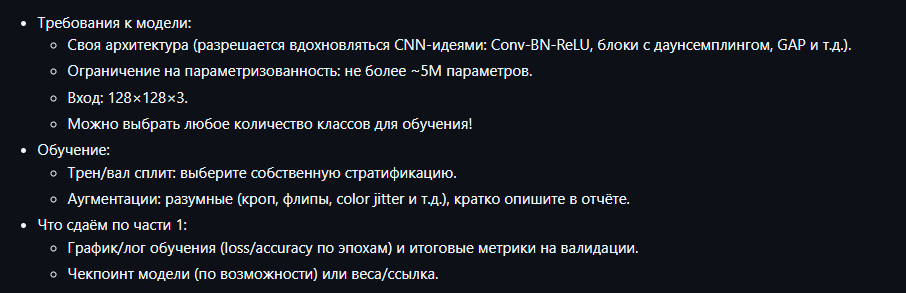

In [27]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.activation = nn.GELU()

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.activation(out)
        return out

In [28]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[1,1,1,1]):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.gelu = nn.GELU()

        self.layer1 = self._make_layer(32, 32,  num_blocks=num_blocks[0], stride=1)
        self.layer2 = self._make_layer(32, 64,  num_blocks=num_blocks[1], stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=num_blocks[2], stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.gelu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [29]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    total_correct = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    epoch_loss = total_loss / len(loader.dataset)
    epoch_acc = total_correct / len(loader.dataset)

    return epoch_loss, epoch_acc

def validate_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_correct = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Val", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item() * images.size(0)
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    epoch_loss = total_loss / len(loader.dataset)
    epoch_acc = total_correct / len(loader.dataset)

    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, device, lr=0.001, epochs=25,
                optimizer_name="adam", save_path="best_model_classifier.pth"):
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()

    if optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Для отслеживания лучшей модели
    best_val_acc = 0.0

    print(f"Training for {epochs} epochs...\n")

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}:")

        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_acc = validate_epoch(model, val_loader, loss_fn, device)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"  Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # Сохраняем лучшую модель
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, save_path)
            print(f"  ✓ Saved best model with val_acc: {val_acc:.4f}")

    print(f"\nTraining finished! Best val accuracy: {best_val_acc:.4f}")
    print(f"Best model saved to: {save_path}")

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "val_loss": val_losses,
        "val_acc": val_accs,
    }

    return model, history

In [30]:
model_Resnet = ResNet()
print(f"Всего параметров: {sum(p.numel() for p in model_Resnet.parameters()):,}")
test_input = torch.randn(1, 3, 64, 64)
output = model_Resnet(test_input)
print(output.shape)

Всего параметров: 1,228,970
torch.Size([1, 10])


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [125]:
model_Resnet, history_Resnet = train_model(
    model_Resnet,
    train_loader,
    val_loader,
    device,
    lr=0.001,
    epochs=40,
    save_path="resnet_classifier.pth"
)


Training for 40 epochs...

Epoch 1/40:


  Train Loss: 0.8958 | Train Acc: 0.6873
  Val   Loss: 0.8754 | Val   Acc: 0.6645
  ✓ Saved best model with val_acc: 0.6645
Epoch 2/40:


  Train Loss: 0.8760 | Train Acc: 0.6914
  Val   Loss: 1.1745 | Val   Acc: 0.6018
Epoch 3/40:


  Train Loss: 0.8477 | Train Acc: 0.7075
  Val   Loss: 0.8782 | Val   Acc: 0.6909
  ✓ Saved best model with val_acc: 0.6909
Epoch 4/40:


  Train Loss: 0.8163 | Train Acc: 0.7134
  Val   Loss: 0.9637 | Val   Acc: 0.6673
Epoch 5/40:


  Train Loss: 0.8274 | Train Acc: 0.7111
  Val   Loss: 0.9794 | Val   Acc: 0.6645
Epoch 6/40:


  Train Loss: 0.8050 | Train Acc: 0.7136
  Val   Loss: 0.8296 | Val   Acc: 0.7145
  ✓ Saved best model with val_acc: 0.7145
Epoch 7/40:


  Train Loss: 0.8024 | Train Acc: 0.7218
  Val   Loss: 0.8042 | Val   Acc: 0.7373
  ✓ Saved best model with val_acc: 0.7373
Epoch 8/40:


  Train Loss: 0.7608 | Train Acc: 0.7336
  Val   Loss: 0.8929 | Val   Acc: 0.6818
Epoch 9/40:


  Train Loss: 0.7480 | Train Acc: 0.7380
  Val   Loss: 0.7902 | Val   Acc: 0.7164
Epoch 10/40:


  Train Loss: 0.7452 | Train Acc: 0.7332
  Val   Loss: 0.9194 | Val   Acc: 0.6736
Epoch 11/40:


  Train Loss: 0.7461 | Train Acc: 0.7361
  Val   Loss: 0.8654 | Val   Acc: 0.6918
Epoch 12/40:


  Train Loss: 0.7309 | Train Acc: 0.7448
  Val   Loss: 0.8298 | Val   Acc: 0.6918
Epoch 13/40:


  Train Loss: 0.7175 | Train Acc: 0.7443
  Val   Loss: 1.1655 | Val   Acc: 0.6355
Epoch 14/40:


  Train Loss: 0.7194 | Train Acc: 0.7502
  Val   Loss: 1.0494 | Val   Acc: 0.6382
Epoch 15/40:


  Train Loss: 0.6780 | Train Acc: 0.7657
  Val   Loss: 1.0158 | Val   Acc: 0.6655
Epoch 16/40:


  Train Loss: 0.6861 | Train Acc: 0.7573
  Val   Loss: 0.8442 | Val   Acc: 0.7064
Epoch 17/40:


  Train Loss: 0.6509 | Train Acc: 0.7698
  Val   Loss: 0.7895 | Val   Acc: 0.7091
Epoch 18/40:


  Train Loss: 0.6222 | Train Acc: 0.7793
  Val   Loss: 0.7896 | Val   Acc: 0.7182
Epoch 19/40:


  Train Loss: 0.6309 | Train Acc: 0.7750
  Val   Loss: 0.8794 | Val   Acc: 0.7027
Epoch 20/40:


  Train Loss: 0.6209 | Train Acc: 0.7773
  Val   Loss: 0.8158 | Val   Acc: 0.7155
Epoch 21/40:


  Train Loss: 0.6178 | Train Acc: 0.7777
  Val   Loss: 0.8529 | Val   Acc: 0.7164
Epoch 22/40:


  Train Loss: 0.6048 | Train Acc: 0.7873
  Val   Loss: 0.9570 | Val   Acc: 0.6827
Epoch 23/40:


  Train Loss: 0.5820 | Train Acc: 0.7970
  Val   Loss: 0.8154 | Val   Acc: 0.7209
Epoch 24/40:


  Train Loss: 0.5724 | Train Acc: 0.7970
  Val   Loss: 0.8462 | Val   Acc: 0.7018
Epoch 25/40:


  Train Loss: 0.5690 | Train Acc: 0.7927
  Val   Loss: 0.8017 | Val   Acc: 0.7236
Epoch 26/40:


  Train Loss: 0.5491 | Train Acc: 0.8045
  Val   Loss: 1.2828 | Val   Acc: 0.6664
Epoch 27/40:


  Train Loss: 0.5573 | Train Acc: 0.8000
  Val   Loss: 0.9788 | Val   Acc: 0.6645
Epoch 28/40:


  Train Loss: 0.5464 | Train Acc: 0.8052
  Val   Loss: 0.8904 | Val   Acc: 0.7018
Epoch 29/40:


  Train Loss: 0.5337 | Train Acc: 0.8139
  Val   Loss: 0.9573 | Val   Acc: 0.6818
Epoch 30/40:


  Train Loss: 0.5188 | Train Acc: 0.8184
  Val   Loss: 0.8390 | Val   Acc: 0.7264
Epoch 31/40:


  Train Loss: 0.5013 | Train Acc: 0.8248
  Val   Loss: 0.8121 | Val   Acc: 0.7091
Epoch 32/40:


  Train Loss: 0.4981 | Train Acc: 0.8191
  Val   Loss: 0.8038 | Val   Acc: 0.7209
Epoch 33/40:


  Train Loss: 0.4854 | Train Acc: 0.8273
  Val   Loss: 0.8087 | Val   Acc: 0.7282
Epoch 34/40:


  Train Loss: 0.4838 | Train Acc: 0.8216
  Val   Loss: 0.7969 | Val   Acc: 0.7309
Epoch 35/40:


  Train Loss: 0.4549 | Train Acc: 0.8416
  Val   Loss: 0.8626 | Val   Acc: 0.7227
Epoch 36/40:


  Train Loss: 0.4520 | Train Acc: 0.8375
  Val   Loss: 0.7365 | Val   Acc: 0.7436
  ✓ Saved best model with val_acc: 0.7436
Epoch 37/40:


  Train Loss: 0.4450 | Train Acc: 0.8425
  Val   Loss: 0.8952 | Val   Acc: 0.7255
Epoch 38/40:


  Train Loss: 0.4229 | Train Acc: 0.8548
  Val   Loss: 0.8691 | Val   Acc: 0.7082
Epoch 39/40:


  Train Loss: 0.4207 | Train Acc: 0.8548
  Val   Loss: 0.8641 | Val   Acc: 0.7182
Epoch 40/40:


  Train Loss: 0.4254 | Train Acc: 0.8500
  Val   Loss: 0.8695 | Val   Acc: 0.7236

Training finished! Best val accuracy: 0.7436
Best model saved to: resnet_classifier.pth


### Графики

График обучения (loss/accuracy по эпохам) и итоговые метрики на валидации.

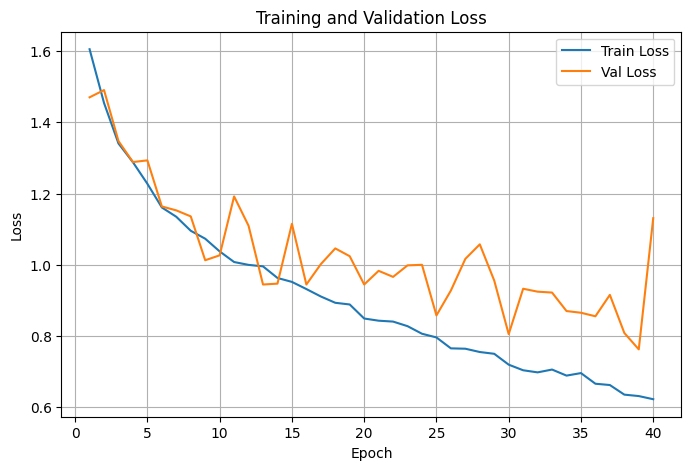

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_Resnet["train_loss"]) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history_Resnet["train_loss"], label="Train Loss")
plt.plot(epochs, history_Resnet["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Часть 2. Базовая U-Net на "Луне"
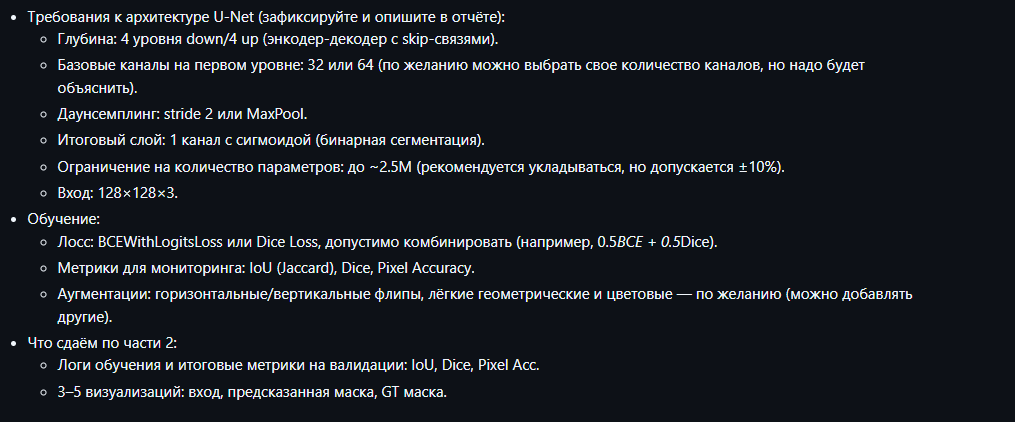

In [6]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground',
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)

        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")

        # Для масок убираем префикс "render" если он есть
        # Например: render0001 - 0001
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32)

        # Применяем аугментации
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

# Аугментации для обучения
train_augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7)),
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2819440945.py:65: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


In [1]:
!unzip -q MOON_SEGMENTATION_BINARY.zip

In [7]:
from sklearn.model_selection import train_test_split

# Путь к данным
DATA_ROOT = "/content/MOON_SEGMENTATION_BINARY"

images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")

Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 20
Батчей в val: 5


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Размер батча изображений: torch.Size([4, 3, 128, 128])
Размер батча масок: torch.Size([4, 128, 128])


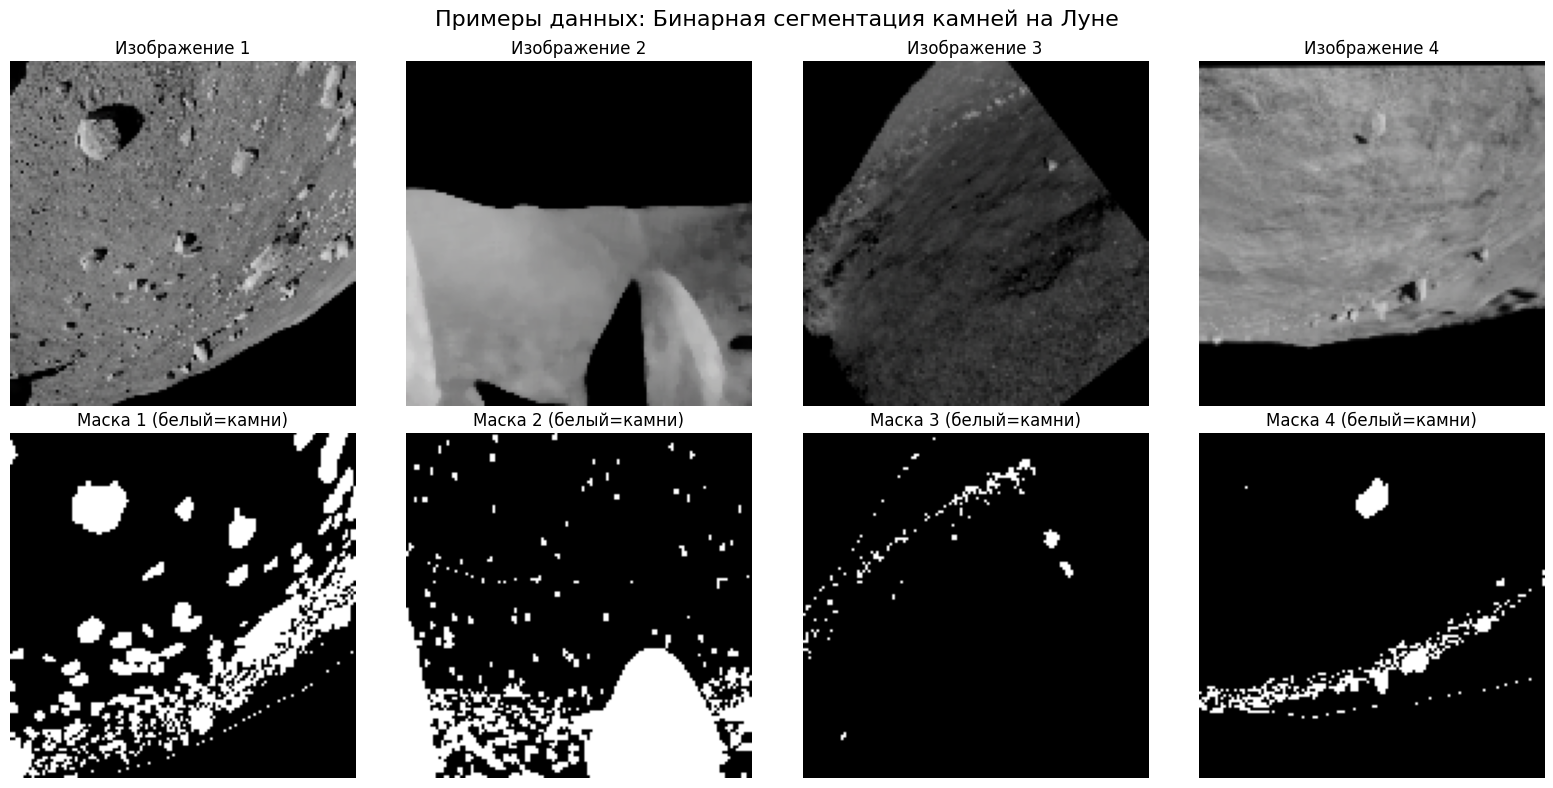

In [8]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

images, masks = next(iter(train_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].numpy()

    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()

## U-NET

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [10]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super(UNet, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")

    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)

            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)

            x = torch.cat([skip_connection, x], dim=1)

            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)

        return output

In [137]:
model = UNet(in_channels=3, out_channels=1, features = [16, 32, 64, 128])

test_input = torch.randn(1, 3, 128, 128)
test_output = model(test_input)
print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 1,944,049
Уровней encoder: 4
Конфигурация каналов: [16, 32, 64, 128]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])


Как-то параметров многовато выходит, если начинать с 32 (аж 7.8М), поэтому начинаю с 16. Пробовала изменить боттлнек, но параметров было все еще многовато

## Функции потерь и метрики для сегментации
Метрики сегментации:
Dice Loss - популярная функция потерь для сегментации

IoU (Intersection over Union) - метрика качества сегментации

Pixel Accuracy - точность предсказания пикселей

In [11]:
class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации

    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)

        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)

        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)

    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)

    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):

    predictions = torch.sigmoid(predictions)
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()

    return (correct / total).item()

In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    pbar = tqdm(train_loader, desc="Training")

    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)

        running_loss += loss.item()
        running_dice += dice
        running_iou += iou

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })

    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)

    return avg_loss, avg_dice, avg_iou


def validate_epoch(model, val_loader, criterion, device):

    model.eval()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0

    pbar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)

            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })

    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)

    return avg_loss, avg_dice, avg_iou, avg_acc

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)

    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }

    best_val_dice = 0.0

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")

        # Здесь происходит основное обучение
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Валидация
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )

        # Обновляем learning rate (проверяем на )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']

        # Сохраняем всю нашу историю
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Выводим результаты
        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")

        # Сохраняем лучшую модель, можно сохранять по метрике или loss
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")

    print(f"Лучший Val Dice: {best_val_dice:.4f}")

    return history

In [14]:
print(f"  Используем устройство: {device}")

NameError: name 'device' is not defined

In [ ]:
# Функция потерь (комбинированная BCE + Dice)
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Планировщик learning rate (уменьшаем lr при плато)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

NUM_EPOCHS = 70

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path='best_moon_unet.pth'
)

Эпоха 1/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.18it/s, loss=0.5502, dice=0.5519, iou=0.3812, acc=0.8615]



 Результаты эпохи 1:
  Train - Loss: 0.6049, Dice: 0.4260, IoU: 0.2750
  Val   - Loss: 0.5378, Dice: 0.5654, IoU: 0.3953, Acc: 0.8423
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5654
Эпоха 2/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.77it/s, loss=0.5433, dice=0.5678, iou=0.3964, acc=0.8682]



 Результаты эпохи 2:
  Train - Loss: 0.5991, Dice: 0.4367, IoU: 0.2870
  Val   - Loss: 0.5370, Dice: 0.5560, IoU: 0.3866, Acc: 0.8500
  LR: 0.000100
Эпоха 3/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.00it/s, loss=0.5403, dice=0.5821, iou=0.4105, acc=0.8615]



 Результаты эпохи 3:
  Train - Loss: 0.5974, Dice: 0.4388, IoU: 0.2898
  Val   - Loss: 0.5448, Dice: 0.5426, IoU: 0.3746, Acc: 0.8397
  LR: 0.000100
Эпоха 4/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.19it/s, loss=0.5516, dice=0.5253, iou=0.3562, acc=0.8695]



 Результаты эпохи 4:
  Train - Loss: 0.5915, Dice: 0.4419, IoU: 0.2948
  Val   - Loss: 0.5389, Dice: 0.5272, IoU: 0.3593, Acc: 0.8629
  LR: 0.000100
Эпоха 5/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.90it/s, loss=0.5512, dice=0.5505, iou=0.3798, acc=0.8534]



 Результаты эпохи 5:
  Train - Loss: 0.5853, Dice: 0.4481, IoU: 0.2974
  Val   - Loss: 0.5383, Dice: 0.5285, IoU: 0.3601, Acc: 0.8551
  LR: 0.000050
Эпоха 6/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.08it/s, loss=0.5495, dice=0.5461, iou=0.3756, acc=0.8566]



 Результаты эпохи 6:
  Train - Loss: 0.5872, Dice: 0.4583, IoU: 0.3044
  Val   - Loss: 0.5320, Dice: 0.5781, IoU: 0.4070, Acc: 0.8540
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.5781
Эпоха 7/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.81it/s, loss=0.5475, dice=0.5379, iou=0.3679, acc=0.8705]



 Результаты эпохи 7:
  Train - Loss: 0.5849, Dice: 0.4646, IoU: 0.3102
  Val   - Loss: 0.5388, Dice: 0.5383, IoU: 0.3691, Acc: 0.8665
  LR: 0.000050
Эпоха 8/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.98it/s, loss=0.5432, dice=0.5577, iou=0.3867, acc=0.8675]



 Результаты эпохи 8:
  Train - Loss: 0.5942, Dice: 0.4204, IoU: 0.2745
  Val   - Loss: 0.5337, Dice: 0.5379, IoU: 0.3703, Acc: 0.8603
  LR: 0.000050
Эпоха 9/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.93it/s, loss=0.5316, dice=0.5860, iou=0.4145, acc=0.8586]



 Результаты эпохи 9:
  Train - Loss: 0.5792, Dice: 0.4635, IoU: 0.3081
  Val   - Loss: 0.5264, Dice: 0.5725, IoU: 0.4020, Acc: 0.8524
  LR: 0.000050
Эпоха 10/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.32it/s, loss=0.5343, dice=0.5784, iou=0.4069, acc=0.8680]



 Результаты эпохи 10:
  Train - Loss: 0.5856, Dice: 0.4379, IoU: 0.2890
  Val   - Loss: 0.5323, Dice: 0.5147, IoU: 0.3500, Acc: 0.8572
  LR: 0.000025
Эпоха 11/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.73it/s, loss=0.5386, dice=0.5687, iou=0.3974, acc=0.8669]



 Результаты эпохи 11:
  Train - Loss: 0.5796, Dice: 0.4624, IoU: 0.3103
  Val   - Loss: 0.5263, Dice: 0.5510, IoU: 0.3822, Acc: 0.8563
  LR: 0.000025
Эпоха 12/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.92it/s, loss=0.5300, dice=0.5758, iou=0.4043, acc=0.8630]



 Результаты эпохи 12:
  Train - Loss: 0.5790, Dice: 0.4618, IoU: 0.3088
  Val   - Loss: 0.5209, Dice: 0.5770, IoU: 0.4063, Acc: 0.8568
  LR: 0.000025
Эпоха 13/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.39it/s, loss=0.5287, dice=0.5775, iou=0.4060, acc=0.8710]



 Результаты эпохи 13:
  Train - Loss: 0.5762, Dice: 0.4573, IoU: 0.3010
  Val   - Loss: 0.5223, Dice: 0.5613, IoU: 0.3913, Acc: 0.8635
  LR: 0.000025
Эпоха 14/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s, loss=0.5309, dice=0.5693, iou=0.3979, acc=0.8735]



 Результаты эпохи 14:
  Train - Loss: 0.5671, Dice: 0.4804, IoU: 0.3248
  Val   - Loss: 0.5229, Dice: 0.5606, IoU: 0.3906, Acc: 0.8641
  LR: 0.000013
Эпоха 15/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.07it/s, loss=0.5366, dice=0.5590, iou=0.3880, acc=0.8698]



 Результаты эпохи 15:
  Train - Loss: 0.5758, Dice: 0.4548, IoU: 0.3048
  Val   - Loss: 0.5255, Dice: 0.5654, IoU: 0.3950, Acc: 0.8620
  LR: 0.000013
Эпоха 16/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.13it/s, loss=0.5360, dice=0.5536, iou=0.3827, acc=0.8667]



 Результаты эпохи 16:
  Train - Loss: 0.5720, Dice: 0.4667, IoU: 0.3131
  Val   - Loss: 0.5228, Dice: 0.5637, IoU: 0.3935, Acc: 0.8633
  LR: 0.000013
Эпоха 17/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.97it/s, loss=0.5371, dice=0.5621, iou=0.3909, acc=0.8645]



 Результаты эпохи 17:
  Train - Loss: 0.5716, Dice: 0.4625, IoU: 0.3084
  Val   - Loss: 0.5284, Dice: 0.5510, IoU: 0.3818, Acc: 0.8618
  LR: 0.000013
Эпоха 18/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.29it/s, loss=0.5464, dice=0.5463, iou=0.3758, acc=0.8645]



 Результаты эпохи 18:
  Train - Loss: 0.5684, Dice: 0.4792, IoU: 0.3251
  Val   - Loss: 0.5380, Dice: 0.5394, IoU: 0.3715, Acc: 0.8602
  LR: 0.000006
Эпоха 19/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.10it/s, loss=0.5352, dice=0.5601, iou=0.3889, acc=0.8614]



 Результаты эпохи 19:
  Train - Loss: 0.5824, Dice: 0.4379, IoU: 0.2897
  Val   - Loss: 0.5295, Dice: 0.5300, IoU: 0.3634, Acc: 0.8597
  LR: 0.000006
Эпоха 20/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.46it/s, loss=0.5398, dice=0.5522, iou=0.3814, acc=0.8590]



 Результаты эпохи 20:
  Train - Loss: 0.5673, Dice: 0.4902, IoU: 0.3321
  Val   - Loss: 0.5289, Dice: 0.5500, IoU: 0.3809, Acc: 0.8582
  LR: 0.000006
Эпоха 21/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s, loss=0.5414, dice=0.5531, iou=0.3823, acc=0.8629]



 Результаты эпохи 21:
  Train - Loss: 0.5677, Dice: 0.4810, IoU: 0.3260
  Val   - Loss: 0.5298, Dice: 0.5646, IoU: 0.3944, Acc: 0.8593
  LR: 0.000006
Эпоха 22/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.64it/s, loss=0.5354, dice=0.5579, iou=0.3869, acc=0.8630]



 Результаты эпохи 22:
  Train - Loss: 0.5724, Dice: 0.4669, IoU: 0.3133
  Val   - Loss: 0.5275, Dice: 0.5375, IoU: 0.3700, Acc: 0.8588
  LR: 0.000003
Эпоха 23/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.75it/s, loss=0.5374, dice=0.5637, iou=0.3924, acc=0.8650]



 Результаты эпохи 23:
  Train - Loss: 0.5701, Dice: 0.4604, IoU: 0.3100
  Val   - Loss: 0.5307, Dice: 0.5392, IoU: 0.3719, Acc: 0.8560
  LR: 0.000003
Эпоха 24/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.86it/s, loss=0.5392, dice=0.5582, iou=0.3871, acc=0.8677]



 Результаты эпохи 24:
  Train - Loss: 0.5711, Dice: 0.4613, IoU: 0.3097
  Val   - Loss: 0.5287, Dice: 0.5382, IoU: 0.3707, Acc: 0.8606
  LR: 0.000003
Эпоха 25/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.90it/s, loss=0.5327, dice=0.5623, iou=0.3911, acc=0.8694]



 Результаты эпохи 25:
  Train - Loss: 0.5766, Dice: 0.4651, IoU: 0.3088
  Val   - Loss: 0.5230, Dice: 0.5451, IoU: 0.3772, Acc: 0.8616
  LR: 0.000003
Эпоха 26/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.98it/s, loss=0.5329, dice=0.5633, iou=0.3921, acc=0.8609]



 Результаты эпохи 26:
  Train - Loss: 0.5755, Dice: 0.4515, IoU: 0.3007
  Val   - Loss: 0.5240, Dice: 0.5541, IoU: 0.3851, Acc: 0.8540
  LR: 0.000002
Эпоха 27/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.48it/s, loss=0.5336, dice=0.5583, iou=0.3872, acc=0.8611]



 Результаты эпохи 27:
  Train - Loss: 0.5734, Dice: 0.4608, IoU: 0.3065
  Val   - Loss: 0.5232, Dice: 0.5439, IoU: 0.3757, Acc: 0.8554
  LR: 0.000002
Эпоха 28/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.89it/s, loss=0.5352, dice=0.5548, iou=0.3838, acc=0.8645]



 Результаты эпохи 28:
  Train - Loss: 0.5663, Dice: 0.4767, IoU: 0.3199
  Val   - Loss: 0.5249, Dice: 0.5498, IoU: 0.3812, Acc: 0.8580
  LR: 0.000002
Эпоха 29/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.69it/s, loss=0.5320, dice=0.5621, iou=0.3909, acc=0.8642]



 Результаты эпохи 29:
  Train - Loss: 0.5766, Dice: 0.4464, IoU: 0.2972
  Val   - Loss: 0.5232, Dice: 0.5506, IoU: 0.3824, Acc: 0.8555
  LR: 0.000002
Эпоха 30/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.35it/s, loss=0.5367, dice=0.5633, iou=0.3920, acc=0.8635]



 Результаты эпохи 30:
  Train - Loss: 0.5689, Dice: 0.4728, IoU: 0.3177
  Val   - Loss: 0.5291, Dice: 0.5452, IoU: 0.3771, Acc: 0.8566
  LR: 0.000001
Эпоха 31/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.01it/s, loss=0.5342, dice=0.5638, iou=0.3926, acc=0.8665]



 Результаты эпохи 31:
  Train - Loss: 0.5671, Dice: 0.4760, IoU: 0.3188
  Val   - Loss: 0.5252, Dice: 0.5467, IoU: 0.3784, Acc: 0.8591
  LR: 0.000001
Эпоха 32/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s, loss=0.5321, dice=0.5599, iou=0.3888, acc=0.8648]



 Результаты эпохи 32:
  Train - Loss: 0.5683, Dice: 0.4729, IoU: 0.3183
  Val   - Loss: 0.5218, Dice: 0.5440, IoU: 0.3759, Acc: 0.8587
  LR: 0.000001
Эпоха 33/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.50it/s, loss=0.5295, dice=0.5584, iou=0.3873, acc=0.8685]



 Результаты эпохи 33:
  Train - Loss: 0.5712, Dice: 0.4643, IoU: 0.3109
  Val   - Loss: 0.5195, Dice: 0.5460, IoU: 0.3780, Acc: 0.8620
  LR: 0.000001
Эпоха 34/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.01it/s, loss=0.5301, dice=0.5645, iou=0.3932, acc=0.8648]



 Результаты эпохи 34:
  Train - Loss: 0.5687, Dice: 0.4734, IoU: 0.3171
  Val   - Loss: 0.5232, Dice: 0.5388, IoU: 0.3713, Acc: 0.8571
  LR: 0.000000
Эпоха 35/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.92it/s, loss=0.5297, dice=0.5645, iou=0.3932, acc=0.8655]



 Результаты эпохи 35:
  Train - Loss: 0.5708, Dice: 0.4599, IoU: 0.3124
  Val   - Loss: 0.5209, Dice: 0.5478, IoU: 0.3797, Acc: 0.8564
  LR: 0.000000
Эпоха 36/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s, loss=0.5360, dice=0.5607, iou=0.3896, acc=0.8626]



 Результаты эпохи 36:
  Train - Loss: 0.5657, Dice: 0.4837, IoU: 0.3292
  Val   - Loss: 0.5266, Dice: 0.5440, IoU: 0.3759, Acc: 0.8546
  LR: 0.000000
Эпоха 37/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.98it/s, loss=0.5377, dice=0.5619, iou=0.3907, acc=0.8649]



 Результаты эпохи 37:
  Train - Loss: 0.5656, Dice: 0.4787, IoU: 0.3222
  Val   - Loss: 0.5278, Dice: 0.5520, IoU: 0.3830, Acc: 0.8574
  LR: 0.000000
Эпоха 38/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.00it/s, loss=0.5341, dice=0.5661, iou=0.3948, acc=0.8639]



 Результаты эпохи 38:
  Train - Loss: 0.5678, Dice: 0.4709, IoU: 0.3182
  Val   - Loss: 0.5244, Dice: 0.5582, IoU: 0.3888, Acc: 0.8570
  LR: 0.000000
Эпоха 39/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.96it/s, loss=0.5352, dice=0.5629, iou=0.3917, acc=0.8654]



 Результаты эпохи 39:
  Train - Loss: 0.5785, Dice: 0.4476, IoU: 0.2987
  Val   - Loss: 0.5258, Dice: 0.5527, IoU: 0.3836, Acc: 0.8597
  LR: 0.000000
Эпоха 40/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.16it/s, loss=0.5370, dice=0.5624, iou=0.3912, acc=0.8686]



 Результаты эпохи 40:
  Train - Loss: 0.5678, Dice: 0.4810, IoU: 0.3245
  Val   - Loss: 0.5286, Dice: 0.5507, IoU: 0.3815, Acc: 0.8620
  LR: 0.000000
Эпоха 41/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.89it/s, loss=0.5376, dice=0.5603, iou=0.3892, acc=0.8639]



 Результаты эпохи 41:
  Train - Loss: 0.5723, Dice: 0.4625, IoU: 0.3066
  Val   - Loss: 0.5278, Dice: 0.5465, IoU: 0.3771, Acc: 0.8602
  LR: 0.000000
Эпоха 42/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.13it/s, loss=0.5276, dice=0.5713, iou=0.3999, acc=0.8667]



 Результаты эпохи 42:
  Train - Loss: 0.5780, Dice: 0.4393, IoU: 0.2886
  Val   - Loss: 0.5199, Dice: 0.5471, IoU: 0.3789, Acc: 0.8576
  LR: 0.000000
Эпоха 43/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.54it/s, loss=0.5346, dice=0.5605, iou=0.3893, acc=0.8624]



 Результаты эпохи 43:
  Train - Loss: 0.5783, Dice: 0.4497, IoU: 0.2986
  Val   - Loss: 0.5262, Dice: 0.5510, IoU: 0.3819, Acc: 0.8564
  LR: 0.000000
Эпоха 44/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.64it/s, loss=0.5324, dice=0.5656, iou=0.3943, acc=0.8614]



 Результаты эпохи 44:
  Train - Loss: 0.5712, Dice: 0.4601, IoU: 0.3061
  Val   - Loss: 0.5233, Dice: 0.5526, IoU: 0.3836, Acc: 0.8545
  LR: 0.000000
Эпоха 45/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.37it/s, loss=0.5352, dice=0.5620, iou=0.3908, acc=0.8616]



 Результаты эпохи 45:
  Train - Loss: 0.5710, Dice: 0.4719, IoU: 0.3158
  Val   - Loss: 0.5258, Dice: 0.5478, IoU: 0.3787, Acc: 0.8567
  LR: 0.000000
Эпоха 46/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.00it/s, loss=0.5365, dice=0.5586, iou=0.3875, acc=0.8601]



 Результаты эпохи 46:
  Train - Loss: 0.5763, Dice: 0.4479, IoU: 0.2991
  Val   - Loss: 0.5264, Dice: 0.5560, IoU: 0.3872, Acc: 0.8555
  LR: 0.000000
Эпоха 47/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.90it/s, loss=0.5335, dice=0.5601, iou=0.3890, acc=0.8656]



 Результаты эпохи 47:
  Train - Loss: 0.5756, Dice: 0.4564, IoU: 0.3050
  Val   - Loss: 0.5236, Dice: 0.5485, IoU: 0.3802, Acc: 0.8600
  LR: 0.000000
Эпоха 48/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.36it/s, loss=0.5284, dice=0.5676, iou=0.3963, acc=0.8678]



 Результаты эпохи 48:
  Train - Loss: 0.5755, Dice: 0.4547, IoU: 0.3029
  Val   - Loss: 0.5203, Dice: 0.5464, IoU: 0.3781, Acc: 0.8586
  LR: 0.000000
Эпоха 49/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s, loss=0.5358, dice=0.5610, iou=0.3898, acc=0.8662]



 Результаты эпохи 49:
  Train - Loss: 0.5685, Dice: 0.4736, IoU: 0.3164
  Val   - Loss: 0.5256, Dice: 0.5443, IoU: 0.3760, Acc: 0.8593
  LR: 0.000000
Эпоха 50/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.33it/s, loss=0.5323, dice=0.5647, iou=0.3934, acc=0.8629]



 Результаты эпохи 50:
  Train - Loss: 0.5700, Dice: 0.4739, IoU: 0.3212
  Val   - Loss: 0.5241, Dice: 0.5517, IoU: 0.3835, Acc: 0.8552
  LR: 0.000000
Эпоха 51/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.05it/s, loss=0.5369, dice=0.5587, iou=0.3877, acc=0.8636]



 Результаты эпохи 51:
  Train - Loss: 0.5693, Dice: 0.4726, IoU: 0.3203
  Val   - Loss: 0.5300, Dice: 0.5421, IoU: 0.3743, Acc: 0.8575
  LR: 0.000000
Эпоха 52/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.55it/s, loss=0.5337, dice=0.5620, iou=0.3908, acc=0.8651]



 Результаты эпохи 52:
  Train - Loss: 0.5679, Dice: 0.4800, IoU: 0.3254
  Val   - Loss: 0.5266, Dice: 0.5427, IoU: 0.3747, Acc: 0.8596
  LR: 0.000000
Эпоха 53/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.53it/s, loss=0.5310, dice=0.5652, iou=0.3940, acc=0.8653]



 Результаты эпохи 53:
  Train - Loss: 0.5752, Dice: 0.4530, IoU: 0.3057
  Val   - Loss: 0.5240, Dice: 0.5453, IoU: 0.3772, Acc: 0.8572
  LR: 0.000000
Эпоха 54/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.33it/s, loss=0.5351, dice=0.5591, iou=0.3880, acc=0.8640]



 Результаты эпохи 54:
  Train - Loss: 0.5608, Dice: 0.5088, IoU: 0.3459
  Val   - Loss: 0.5240, Dice: 0.5560, IoU: 0.3869, Acc: 0.8580
  LR: 0.000000
Эпоха 55/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.49it/s, loss=0.5324, dice=0.5606, iou=0.3895, acc=0.8622]



 Результаты эпохи 55:
  Train - Loss: 0.5660, Dice: 0.4844, IoU: 0.3289
  Val   - Loss: 0.5218, Dice: 0.5579, IoU: 0.3888, Acc: 0.8560
  LR: 0.000000
Эпоха 56/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.61it/s, loss=0.5381, dice=0.5603, iou=0.3892, acc=0.8605]



 Результаты эпохи 56:
  Train - Loss: 0.5736, Dice: 0.4598, IoU: 0.3101
  Val   - Loss: 0.5331, Dice: 0.5545, IoU: 0.3853, Acc: 0.8543
  LR: 0.000000
Эпоха 57/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.00it/s, loss=0.5342, dice=0.5654, iou=0.3941, acc=0.8611]



 Результаты эпохи 57:
  Train - Loss: 0.5735, Dice: 0.4589, IoU: 0.3075
  Val   - Loss: 0.5256, Dice: 0.5490, IoU: 0.3801, Acc: 0.8549
  LR: 0.000000
Эпоха 58/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.58it/s, loss=0.5361, dice=0.5601, iou=0.3890, acc=0.8621]



 Результаты эпохи 58:
  Train - Loss: 0.5727, Dice: 0.4631, IoU: 0.3095
  Val   - Loss: 0.5271, Dice: 0.5387, IoU: 0.3712, Acc: 0.8576
  LR: 0.000000
Эпоха 59/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s, loss=0.5411, dice=0.5531, iou=0.3822, acc=0.8616]



 Результаты эпохи 59:
  Train - Loss: 0.5628, Dice: 0.5048, IoU: 0.3467
  Val   - Loss: 0.5284, Dice: 0.5614, IoU: 0.3912, Acc: 0.8584
  LR: 0.000000
Эпоха 60/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.18it/s, loss=0.5350, dice=0.5631, iou=0.3919, acc=0.8646]



 Результаты эпохи 60:
  Train - Loss: 0.5696, Dice: 0.4736, IoU: 0.3182
  Val   - Loss: 0.5268, Dice: 0.5609, IoU: 0.3909, Acc: 0.8576
  LR: 0.000000
Эпоха 61/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.09it/s, loss=0.5447, dice=0.5483, iou=0.3777, acc=0.8607]



 Результаты эпохи 61:
  Train - Loss: 0.5612, Dice: 0.5036, IoU: 0.3413
  Val   - Loss: 0.5316, Dice: 0.5616, IoU: 0.3914, Acc: 0.8565
  LR: 0.000000
Эпоха 62/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s, loss=0.5395, dice=0.5521, iou=0.3814, acc=0.8568]



 Результаты эпохи 62:
  Train - Loss: 0.5698, Dice: 0.4795, IoU: 0.3242
  Val   - Loss: 0.5273, Dice: 0.5558, IoU: 0.3868, Acc: 0.8525
  LR: 0.000000
Эпоха 63/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.45it/s, loss=0.5381, dice=0.5560, iou=0.3850, acc=0.8632]



 Результаты эпохи 63:
  Train - Loss: 0.5753, Dice: 0.4606, IoU: 0.3082
  Val   - Loss: 0.5254, Dice: 0.5450, IoU: 0.3766, Acc: 0.8583
  LR: 0.000000
Эпоха 64/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.37it/s, loss=0.5363, dice=0.5638, iou=0.3925, acc=0.8640]



 Результаты эпохи 64:
  Train - Loss: 0.5615, Dice: 0.5001, IoU: 0.3375
  Val   - Loss: 0.5269, Dice: 0.5472, IoU: 0.3784, Acc: 0.8571
  LR: 0.000000
Эпоха 65/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s, loss=0.5397, dice=0.5625, iou=0.3913, acc=0.8671]



 Результаты эпохи 65:
  Train - Loss: 0.5621, Dice: 0.4960, IoU: 0.3389
  Val   - Loss: 0.5303, Dice: 0.5376, IoU: 0.3705, Acc: 0.8583
  LR: 0.000000
Эпоха 66/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s, loss=0.5313, dice=0.5712, iou=0.3998, acc=0.8676]



 Результаты эпохи 66:
  Train - Loss: 0.5755, Dice: 0.4562, IoU: 0.3025
  Val   - Loss: 0.5243, Dice: 0.5450, IoU: 0.3769, Acc: 0.8601
  LR: 0.000000
Эпоха 67/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s, loss=0.5334, dice=0.5618, iou=0.3907, acc=0.8681]



 Результаты эпохи 67:
  Train - Loss: 0.5617, Dice: 0.5021, IoU: 0.3410
  Val   - Loss: 0.5249, Dice: 0.5392, IoU: 0.3717, Acc: 0.8615
  LR: 0.000000
Эпоха 68/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.58it/s, loss=0.5336, dice=0.5614, iou=0.3903, acc=0.8648]



 Результаты эпохи 68:
  Train - Loss: 0.5703, Dice: 0.4647, IoU: 0.3096
  Val   - Loss: 0.5238, Dice: 0.5489, IoU: 0.3800, Acc: 0.8603
  LR: 0.000000
Эпоха 69/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.79it/s, loss=0.5298, dice=0.5705, iou=0.3991, acc=0.8614]



 Результаты эпохи 69:
  Train - Loss: 0.5691, Dice: 0.4735, IoU: 0.3168
  Val   - Loss: 0.5228, Dice: 0.5494, IoU: 0.3811, Acc: 0.8522
  LR: 0.000000
Эпоха 70/70


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.56it/s, loss=0.5327, dice=0.5627, iou=0.3915, acc=0.8645]


 Результаты эпохи 70:
  Train - Loss: 0.5699, Dice: 0.4617, IoU: 0.3119
  Val   - Loss: 0.5234, Dice: 0.5410, IoU: 0.3732, Acc: 0.8588
  LR: 0.000000
Лучший Val Dice: 0.5781


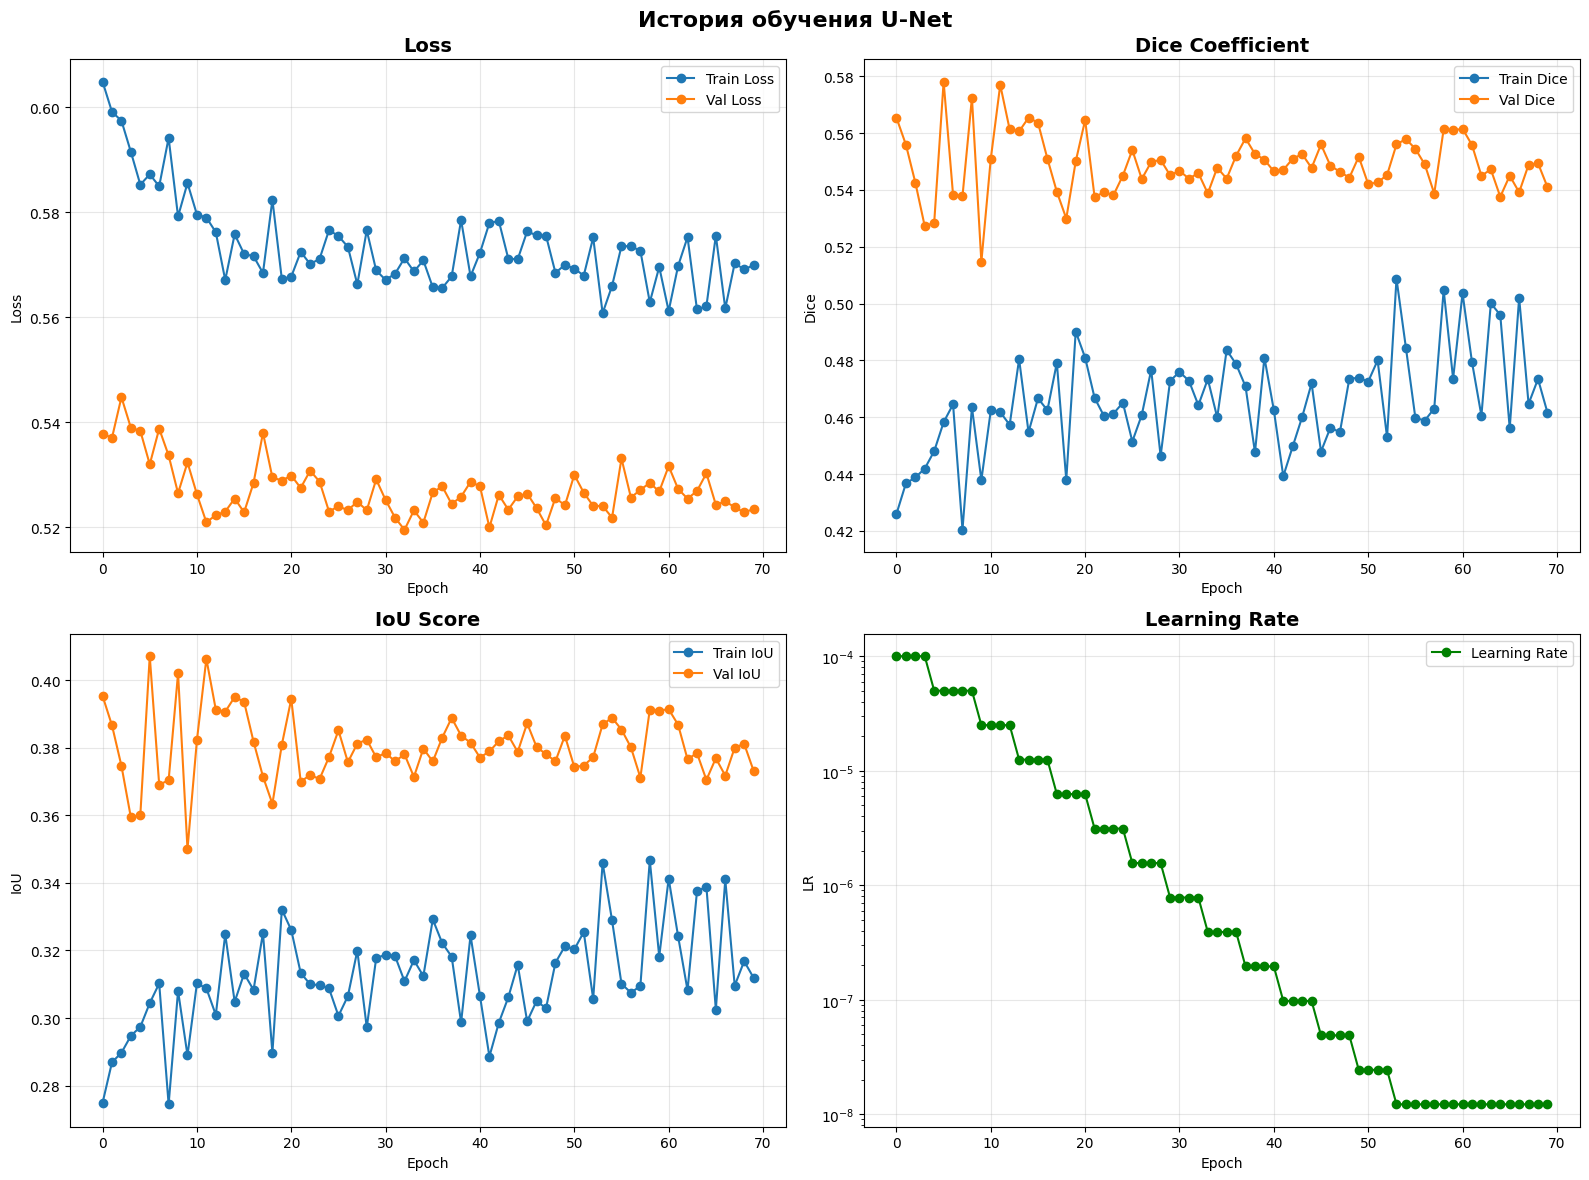

Train Loss: 0.5699
Val Loss: 0.5234
Train Dice: 0.4617
Val Dice: 0.5410
Train IoU: 0.3119
Val IoU: 0.3732
Val Accuracy: 0.8588


In [80]:
def plot_training_history(history):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='o')
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # IoU Score
    axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o')
    axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='o')
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 1].plot(history['lr'], label='Learning Rate', marker='o', color='green')
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('История обучения U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Train Dice: {history['train_dice'][-1]:.4f}")
    print(f"Val Dice: {history['val_dice'][-1]:.4f}")
    print(f"Train IoU: {history['train_iou'][-1]:.4f}")
    print(f"Val IoU: {history['val_iou'][-1]:.4f}")
    print(f"Val Accuracy: {history['val_acc'][-1]:.4f}")

plot_training_history(history)

In [86]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

def visualize_predictions(model, dataloader, device, num_samples=4):

    model.eval()
    model.to(device)
    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break
    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]

    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        predictions = model(images)
        predictions = (predictions > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if min(num_samples, len(images)) == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :,:].numpy()
        mask_pred = predictions[i, 0].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')

        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')

        dice = dice_coefficient(predictions[i:i+1], masks[i:i+1])
        iou = iou_score(predictions[i:i+1], masks[i:i+1])


        axes[i, 3].text(
            0.5, -0.15,
            f'Dice: {dice:.4f}   |   IoU: {iou:.4f}',
            transform=axes[i, 3].transAxes,
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="none")
        )

    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

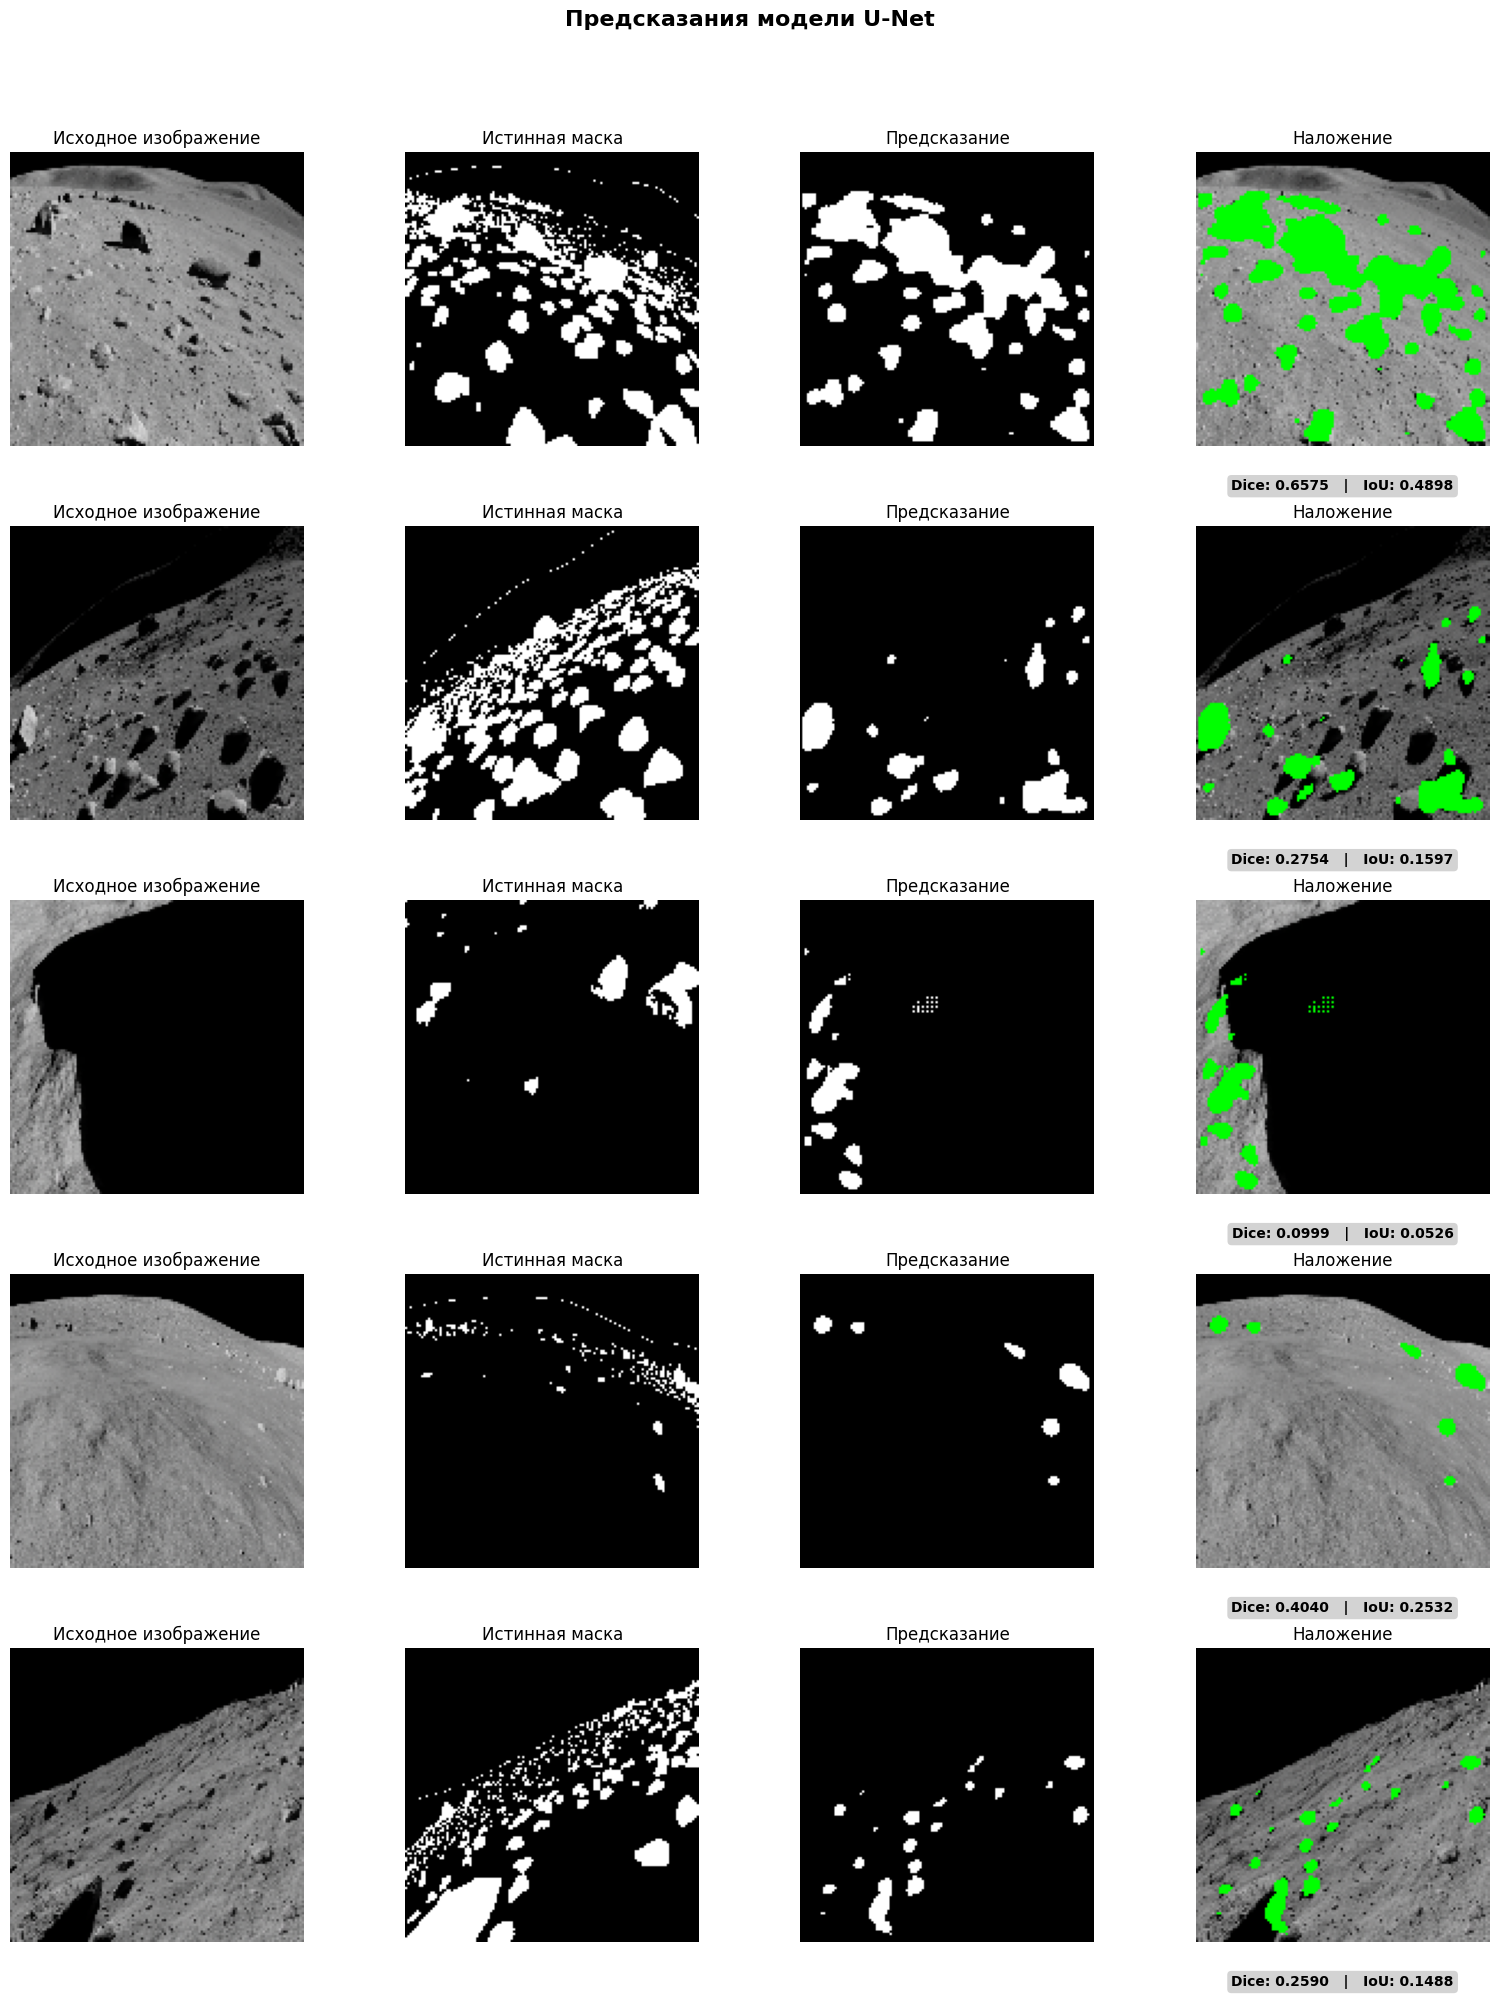

In [87]:
visualize_predictions(model, val_loader, device, num_samples=5)

### Часть 3. U-Net с бэкбоном из классификатора
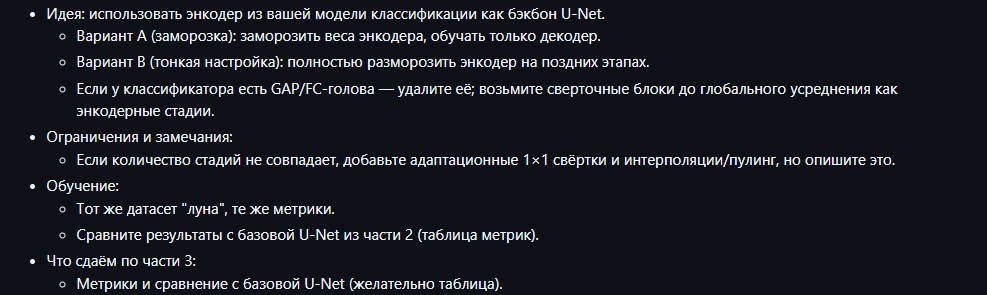

In [118]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x):
        return self.double_conv(x)

In [130]:
class ResNetUNet(nn.Module):
    def __init__(self, out_channels=1, freeze_encoder=False):
        super(ResNetUNet, self).__init__()

        # предобученный классификатор из ч.1
        classifier = ResNet(num_classes=10, num_blocks=[1,1,1,1])

        checkpoint = torch.load('resnet_classifier.pth', map_location='cpu')
        if 'model_state_dict' in checkpoint:
            classifier.load_state_dict(checkpoint['model_state_dict'])
        else:
            classifier.load_state_dict(checkpoint)

        # слои энкодера
        self.enc0 = nn.Sequential(
            classifier.conv1,
            classifier.bn1,
            classifier.gelu
        )  # [B, 32, 128, 128]

        self.enc1 = classifier.layer1  # [B, 32, 128, 128]
        self.enc2 = classifier.layer2  # [B, 64, 64, 64]
        self.enc3 = classifier.layer3  # [B, 128, 32, 32]
        self.enc4 = classifier.layer4  # [B, 256, 16, 16]

        # замораживаем энкодер
        if freeze_encoder:
            for enc in [self.enc0, self.enc1, self.enc2, self.enc3, self.enc4]:
                for param in enc.parameters():
                    param.requires_grad = False

        # декодер
        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(64 + 64, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(32 + 32, 32)

        self.up1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(32 + 32, 32)

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # энкодер
        x0 = self.enc0(x)   # [B, 32, 128, 128]
        x1 = self.enc1(x0)  # [B, 32, 128, 128]
        x2 = self.enc2(x1)  # [B, 64, 64, 64]
        x3 = self.enc3(x2)  # [B, 128, 32, 32]
        x4 = self.enc4(x3)  # [B, 256, 16, 16]

        # декодер
        d4 = self.up4(x4)                  # [B, 128, 32, 32]
        d4 = torch.cat([d4, x3], dim=1)    # [B, 256, 32, 32]
        d4 = self.dec4(d4)                 # [B, 128, 32, 32]

        d3 = self.up3(d4)                  # [B, 64, 64, 64]
        d3 = torch.cat([d3, x2], dim=1)    # [B, 128, 64, 64]
        d3 = self.dec3(d3)                 # [B, 64, 64, 64]

        d2 = self.up2(d3)                  # [B, 32, 128, 128]
        d2 = torch.cat([d2, x1], dim=1)    # [B, 64, 128, 128]
        d2 = self.dec2(d2)                 # [B, 32, 128, 128]

        d1 = self.up1(d2)                  # [B, 32, 256, 256]
        # адаптируем x0 под размер d1
        x0_adapted = F.interpolate(x0, size=d1.shape[2:], mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, x0_adapted], dim=1)  # [B, 64, 256, 256]
        d1 = self.dec1(d1)                 # [B, 32, 256, 256]

        # вернём к размеру 128x128
        d1 = F.interpolate(d1, size=(128, 128), mode='bilinear', align_corners=False)

        out = self.out_conv(d1)            # [B, 1, 128, 128]
        return out

### Вариант A (заморозка): заморозить веса энкодера, обучать только декодер.

In [131]:
# Вариант A: с замороженным энкодером
model_A = ResNetUNet(out_channels=1, freeze_encoder=True)

total_params = sum(p.numel() for p in model_A.parameters())
trainable_params = sum(p.numel() for p in model_A.parameters() if p.requires_grad)

print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


Всего параметров: 2,012,609
Обучаемых параметров: 786,209


In [144]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)

    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }

    best_val_dice = 0.0

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")

        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    print(f"Лучший Val Dice: {best_val_dice:.4f}")

    return history

In [146]:
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(model_A.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

history_unet_A = train_model(
    model=model_A,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=60,
    save_path='best_moon_unet_A.pth'
)

Эпоха 1/60


Training:   0%|          | 0/69 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([64, 1])) must be the same as input size (torch.Size([64, 1, 128, 128]))

# Здесь пока не доделано, потому что у меня закончились вычислительные единицы в Колабе, а нормального компьютера нет :(